In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Conv2D, MaxPooling2D,ZeroPadding2D, Dropout,BatchNormalization
from keras import optimizers
import matplotlib.cm as cm
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator

input_shape=(150,150,3)
img_width=150
img_height=150
batch_size=20
epocs=20

In [2]:
# for training and validation dataset
train_data_dir="./tumor_dataset/Training"
validation_data_dir="./tumor_dataset/Testing"

In [3]:
#creating dataset generator and rescale function
validation_datagen=ImageDataGenerator(
    rescale=1./255
)

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2
)

In [4]:
#preprocessing the data using train and validation data generator 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)

Found 5712 images belonging to 4 classes.
Found 1312 images belonging to 4 classes.


In [5]:
#feature engineering(designing convolution, max pool etc layers)
model=Sequential()

model.add(Conv2D(256,(3,3),input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(256,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())


# model.add(Conv2D(32,(3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# model.add(Conv2D(16,(3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

#flattening the array before fitting into the neural net
model.add(Flatten())

#designing the model

model.add(Dense(1024))
model.add(Activation('relu'))

# model.add(Dense(512))
# model.add(Activation('relu'))

# model.add(Dense(256))
# model.add(Activation('relu'))

# model.add(Dense(128))
# model.add(Activation('relu'))

# model.add(Dense(64))
# model.add(Activation('relu'))

# model.add(Dense(16))
# model.add(Activation('relu'))

# model.add(Dense(8))
# model.add(Activation('relu')) yo layer lai hatauda ni hunxa

model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 256)     7168      
_________________________________________________________________
activation (Activation)      (None, 148, 148, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 256)     590080    
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       2

In [6]:
# conv_base.trainable=False

In [7]:
# initiate RMSprop optimizer and configure some parameters
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint("Tumor_classification_CNN.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_loss', #value being monitored for improvement
                          min_delta = 0.001,  #Abs value and is the main change required before we stop
                          patience = 10, #no of epocs we wait before stopping
                          verbose = 10,
                          restore_best_weights = True) #keep the best weigts once stopped

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.001,
                              patience = 10,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [8]:
#compiling the model
model.compile(loss = 'categorical_crossentropy',
        optimizer = Adam(lr = 0.001),
        metrics = ['accuracy'])

C:\annaconda\envs\tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
train = model.fit_generator(
    train_generator,
    steps_per_epoch = 5712 // batch_size,
    epochs = 200,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = 1311 // batch_size)

C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
285/285 [==============================] - 149s 472ms/step - loss: 3.1991 - accuracy: 0.4947 - val_loss: 2.3046 - val_accuracy: 0.3400

Epoch 00001: val_loss improved from inf to 2.30464, saving model to Tumor_classification_CNN.h5
Epoch 2/200
285/285 [==============================] - 127s 446ms/step - loss: 1.0467 - accuracy: 0.6068 - val_loss: 0.8378 - val_accuracy: 0.6646

Epoch 00002: val_loss improved from 2.30464 to 0.83782, saving model to Tumor_classification_CNN.h5
Epoch 3/200
285/285 [==============================] - 127s 447ms/step - loss: 0.8477 - accuracy: 0.6537 - val_loss: 4.7454 - val_accuracy: 0.5323

Epoch 00003: val_loss did not improve from 0.83782
Epoch 4/200
285/285 [==============================] - 128s 447ms/step - loss: 0.7853 - accuracy: 0.6896 - val_loss: 1.9512 - val_accuracy: 0.5338

Epoch 00004: val_loss did not improve from 0.83782
Epoch 5/200
285/285 [==============================] - 127s 447ms/step - loss: 0.7151 - accuracy: 0.7186 - val

In [10]:
train.history 

{'loss': [3.199143886566162,
  1.0467135906219482,
  0.8477305173873901,
  0.7853394150733948,
  0.7150934338569641,
  0.7178667783737183,
  0.665188729763031,
  0.6406238675117493,
  0.6329764127731323,
  0.5981765985488892,
  0.5932019948959351,
  0.5862324833869934,
  0.5681027770042419,
  0.5271199941635132,
  0.5187413692474365,
  0.48636549711227417,
  0.4696120023727417,
  0.4699379801750183,
  0.42803484201431274,
  0.45573821663856506,
  0.43861886858940125,
  0.4210345447063446,
  0.41543301939964294,
  0.4028669595718384,
  0.407217800617218,
  0.3910067081451416,
  0.4166112542152405,
  0.3783625066280365,
  0.35458335280418396,
  0.33467623591423035,
  0.33630719780921936,
  0.32119494676589966,
  0.3255767822265625,
  0.32647696137428284,
  0.32902511954307556,
  0.3088955283164978,
  0.29591432213783264,
  0.3217609226703644,
  0.3131096661090851,
  0.29388219118118286,
  0.29548439383506775,
  0.28924620151519775,
  0.2835913300514221,
  0.2897114157676697,
  0.27189537

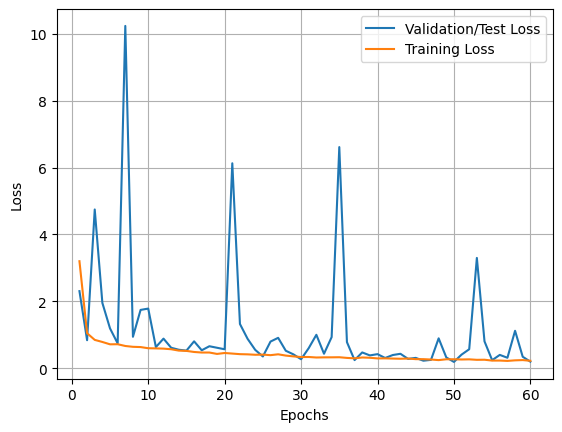

In [11]:
# Plotting our loss charts
import matplotlib.pyplot as plt
epochs=32
history_dict = train.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

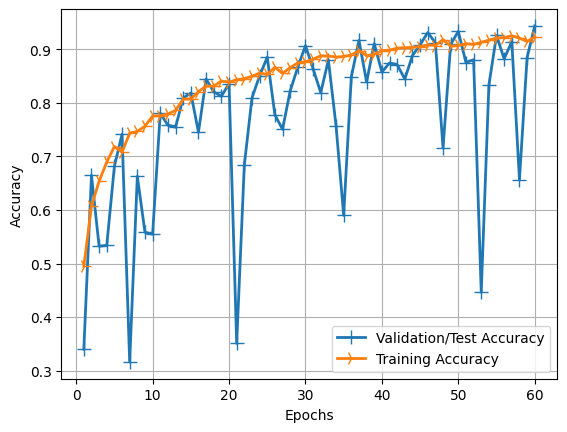

In [12]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = train.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[ 71  49  97  83]
 [ 72  69 102  63]
 [ 98  93 111 104]
 [ 74  64 101  61]]


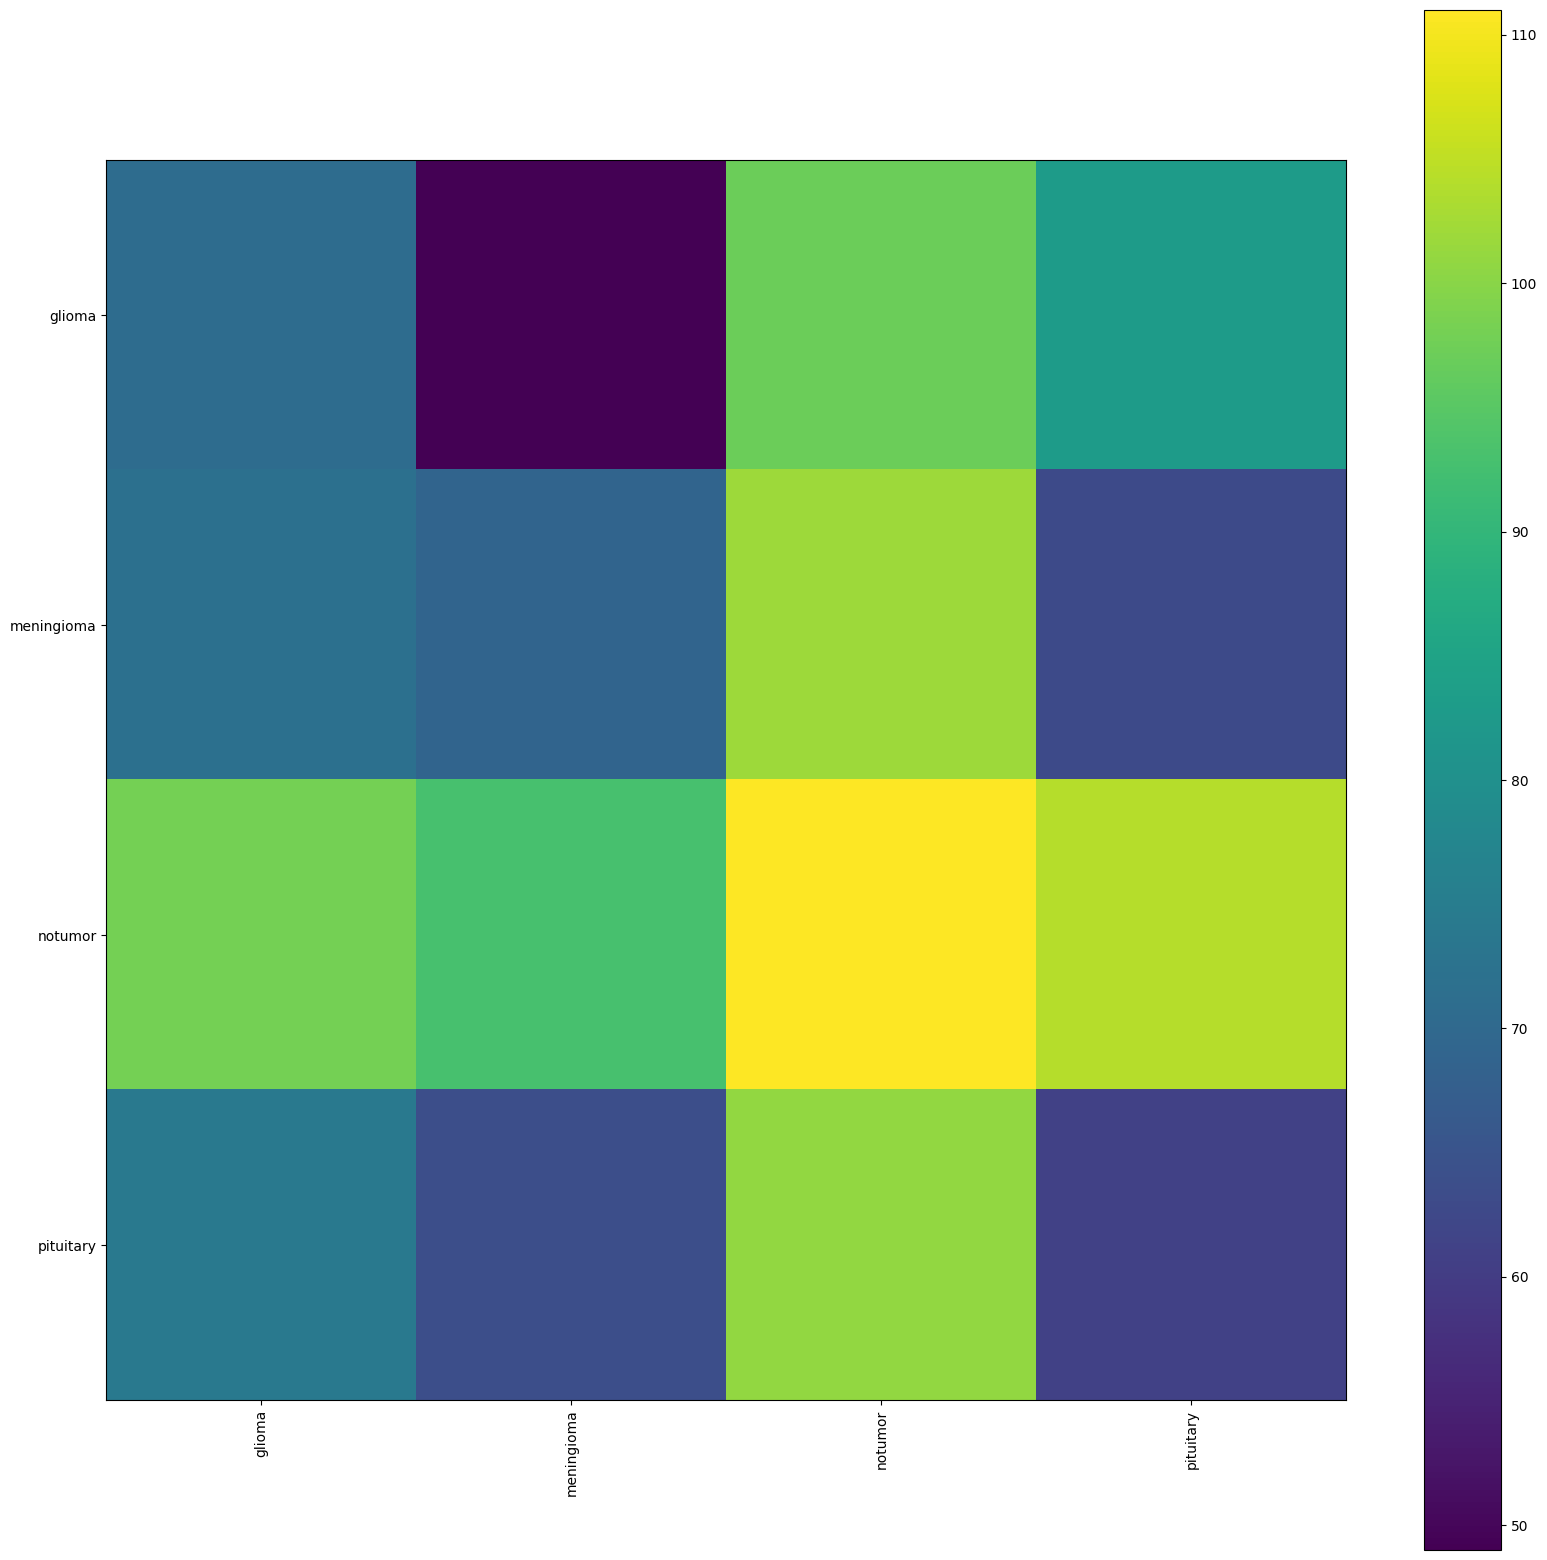

In [15]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 150,150,3


class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 8005
nb_validation_samples = 2023

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print(cnf_matrix)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

(1, 150, 150, 3)
[[0. 0. 1. 0.]]
The category =  No tumor


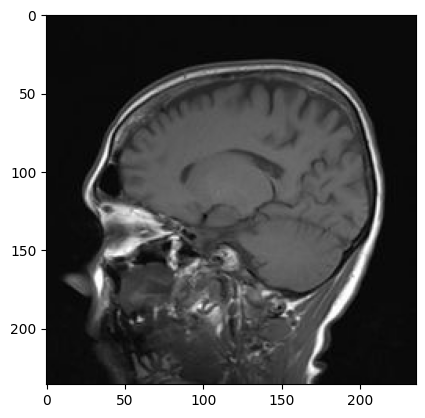

In [23]:
#testing the model on datas from test dataset

import numpy as np
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img

d = {0:'Glioma',1:'meningioma',2:'No tumor',3:'Pituitary'}

image_path = './tumor_dataset/Testing/notumor/Te-no_0015.jpg'
model = models.load_model('Tumor_classification_CNN.h5')
test_image = load_img(image_path,target_size = (150,150,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
print(test_image.shape)
result = model.predict(test_image)
print(result)
testImage = img.imread(image_path)
print("The category = ",d[np.argmax(result)])
# displaying the modified image
plt.imshow(testImage)

In [24]:
#evaluating model performance
test_gen=validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

Found 1312 images belonging to 4 classes.


In [25]:
#predicting the datasets class and value loss(Testing accuracy and loss)
model.evaluate_generator(test_gen,steps=50)

[0.17490647733211517, 0.9390000104904175]